In [3]:
import pandas as pd
df = pd.read_csv('transport_data_output.csv')

In [4]:
df.head(20)

,City of Origin,Destination City,Stopover City,Vehicle Plate,Distance (km),Vehicle Type,Speed (km/h),Fuel Consumption (L/100km),Traffic Congestion,Adjusted Speed (km/h),...,Peak Time,Off-Peak Time,Free-Flow Speed (km/h),Free-Flow Time (hours),Travel Time Index (TTI),Load Weight (pounds),Normalized Distance,Normalized Time,Normalized Fuel,Edge Score
0,Nairobi,Kisumu,Kisumu,NAI-KIS-0000,341.0,Coupe,72.315494,16.788811,High,52.315494,...,7.829561,5.710669,130,2.623077,2.484924,718.438353,0.136849,0.095043,0.082501,0.106749
1,Bujumbura,Gitega,Gitega,BUJ-GIT-0001,98.9,Hybrid,58.895994,5.902852,Medium,58.895994,...,2.011070,1.214930,100,0.989000,1.697908,805.418495,0.000000,0.016493,0.001238,0.003794
2,Nairobi,Bujumbura,Bujumbura,NAI-BUJ-0002,1281.0,Saloon,78.107674,11.786449,High,58.107674,...,25.848074,17.530530,110,11.645455,1.893037,689.438151,0.668193,0.347092,0.230661,0.428960
3,Kampala,Kigali,Kigali,KAM-KIG-0003,511.0,Hybrid,41.858236,6.924270,Medium,41.858236,...,14.344186,10.196452,100,5.110000,2.389016,814.233168,0.232943,0.187403,0.047938,0.149833
4,Kisumu,Bujumbura,Bujumbura,KIS-BUJ-0004,1064.0,Hybrid,41.967992,7.942348,Low,61.967992,...,20.367696,15.099745,100,10.640000,1.613736,940.969123,0.545532,0.267955,0.125584,0.322037
5,Kisumu,Kampala,Kampala,KIS-KAM-0005,324.0,Truck,84.755001,34.739786,High,64.755001,...,5.519865,3.884717,90,3.600000,1.389854,1236.232715,0.127240,0.070455,0.169921,0.132956
6,Lamu Port,Nairobi,Nairobi,LAM-NAI-0006,697.0,Saloon,88.222853,8.293102,Low,108.222853,...,7.192070,4.911576,110,6.336364,1.016421,522.984603,0.338082,0.093781,0.083375,0.187339
7,Nairobi,Arusha,Arusha,NAI-ARU-0007,902.0,Saloon,104.350963,11.129983,Medium,104.350963,...,10.381415,7.629053,110,8.200000,1.054135,646.549718,0.453960,0.129550,0.150694,0.267771
8,Dar es Salaam,Nairobi,Mombasa,DAR-NAI-0008,822.0,Saloon,59.224959,14.373813,High,39.224959,...,23.680843,14.868453,110,7.472727,2.804337,866.006790,0.408739,0.329411,0.178766,0.300884
9,Bujumbura,Gitega,Gitega,BUJ-GIT-0009,98.9,Hybrid,85.448143,10.121937,Low,105.448143,...,1.177773,0.746494,100,0.989000,0.948333,907.241878,0.000000,0.004459,0.007834,0.004025


Epoch 0: Fuel used = 2005.41L, Loss = 3081464.27
Epoch 10: Fuel used = 1701.81L, Loss = 2107752.28
Epoch 20: Fuel used = 1429.23L, Loss = 1390583.39
Epoch 30: Fuel used = 685.38L, Loss = 189553.13
Epoch 40: Fuel used = 961.92L, Loss = 506825.81
Epoch 50: Fuel used = 1304.16L, Loss = 1111253.31
Epoch 60: Fuel used = 953.67L, Loss = 495147.25
Epoch 70: Fuel used = 685.38L, Loss = 189553.13
Epoch 80: Fuel used = 1576.74L, Loss = 1760239.03
Epoch 90: Fuel used = 799.56L, Loss = 302012.90


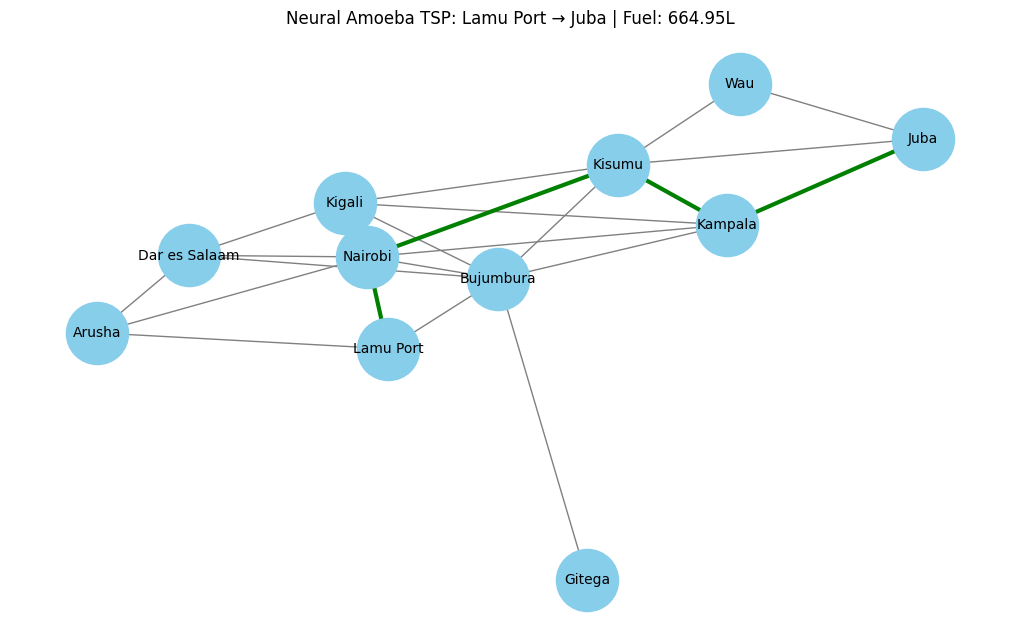

Final path: Lamu Port → Nairobi → Kisumu → Kampala → Juba


In [5]:
# Neural Amoeba TSP - with basic backpropagation and training loop

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load real-world transport dataset
df = pd.read_csv("transport_data_output.csv")

# 2. Build a weighted graph from the dataset
G = nx.Graph()
for _, row in df.iterrows():
    u, v = row['City of Origin'], row['Destination City']
    dist = row['Distance (km)']
    if not G.has_edge(u, v):
        G.add_edge(u, v, weight=dist)

# 3. Vehicle fuel consumption profiles (simplified average values)
fuel_rates = {
    'Truck': 33,
    'Saloon': 9,
    'Hybrid': 6,
    'SUV': 12,
    'Coupe': 10
}

# 4. Define trainable weights per city-pair edge (simulating synapse strengths)
edge_weights = {edge: np.random.rand() for edge in G.edges}

# 5. Define activation function and loss
def activation(x):
    return 1 / (1 + np.exp(-x))  # sigmoid for smooth path selection

def compute_fuel_cost(path, vehicle):
    rate = fuel_rates[vehicle]
    return sum(G[u][v]['weight'] * rate / 100 for u, v in zip(path[:-1], path[1:]))

def loss_fn(predicted_cost, actual_budget):
    return (predicted_cost - actual_budget) ** 2

# 6. Forward pass - guided traversal by learned edge weights
def forward_pass(start, end, vehicle, budget):
    current = start
    path = [current]
    visited = set(path)

    while current != end:
        neighbors = [n for n in G.neighbors(current) if n not in visited]
        if not neighbors:
            break

        # Select next node based on activated edge weights
        scores = [(n, activation(edge_weights.get((current, n), edge_weights.get((n, current), 0)))) for n in neighbors]
        next_node = max(scores, key=lambda x: x[1])[0]

        path.append(next_node)
        visited.add(next_node)
        current = next_node

    fuel_cost = compute_fuel_cost(path, vehicle)
    return path, fuel_cost

# 7. Backpropagation (simple weight update based on gradient of loss)
def update_weights(path, vehicle, budget, lr=0.01):
    pred_cost = compute_fuel_cost(path, vehicle)
    error = pred_cost - budget

    for u, v in zip(path[:-1], path[1:]):
        key = (u, v) if (u, v) in edge_weights else (v, u)
        grad = 2 * error  # d(loss)/d(pred_cost) * d(pred_cost)/d(weight)
        edge_weights[key] -= lr * grad  # gradient descent

# 8. Training Loop
start_city = "Lamu Port"
end_city = "Juba"
vehicle = "Truck"
budget = 250  # Fuel in liters

for epoch in range(100):
    path, cost = forward_pass(start_city, end_city, vehicle, budget)
    update_weights(path, vehicle, budget, lr=0.005)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Fuel used = {cost:.2f}L, Loss = {loss_fn(cost, budget):.2f}")

# 9. Visualize final path
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=10)
path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3)
plt.title(f"Neural Amoeba TSP: {start_city} → {end_city} | Fuel: {cost:.2f}L")
plt.show()

print("Final path:", " → ".join(path))
